2996
2994


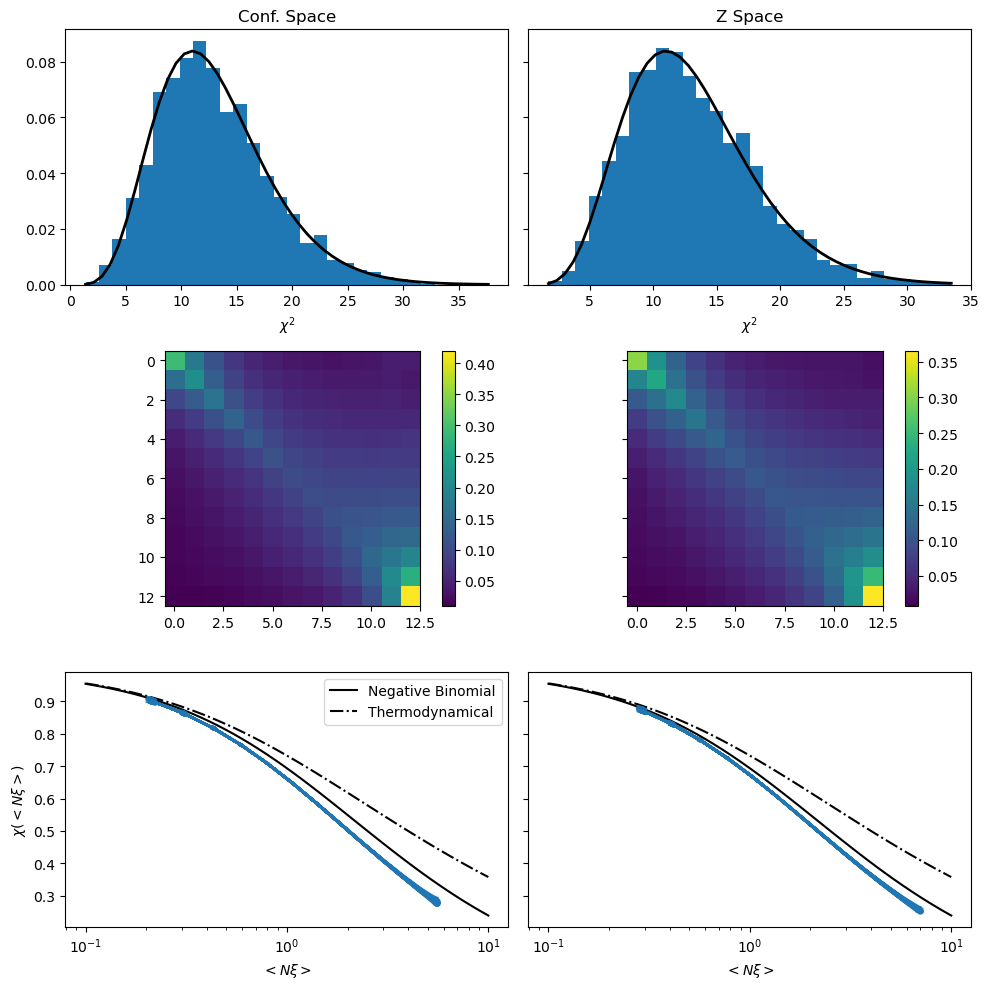

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import glob
from scipy import stats

def NB(x):
    return np.log(1+x)/x
def term(x):
    return (np.sqrt(1+2*x)-1)/x

def compute_mean_cov(summaries):
    mean = np.mean(summaries, axis=0)
    covariance = np.cov(summaries.T)
    inverse_covariance = np.linalg.solve(
        covariance, np.eye(len(covariance), len(covariance))
    )
    return mean, covariance, inverse_covariance

def compute_chisq(vector, mean, inverse_covariance):
    return (vector - mean) @ inverse_covariance @ (vector - mean).T

def plot_chisq(ax,chisq,bins,color,dof):
    ax.hist(np.asarray(chisq).flatten(),bins=bins,color=color,density=True)
    x = np.linspace(np.min(chisq), np.max(chisq))
    ax.plot(x, stats.chi2.pdf(x, dof), label=r"$\chi^2$", color="k", linewidth=2)

def plot_cov(ax,cov):
    row_sums = cov.sum(axis=1)
    new_matrix = cov / row_sums[:, np.newaxis]
    im = ax.imshow(new_matrix)
    plt.colorbar(im,ax=ax)

def plot_rvps(ax,nxis,chis,chi_stds):
    x = np.geomspace(1E-1,1E1,50)
    c='k'
    ax.plot(x,NB(x),label='Negative Binomial',c=c)
    ax.plot(x,term(x),label='Thermodynamical',c=c,ls='-.')
    for i in range(len(chis)):
        ax.errorbar(nxis[i],chis[i],yerr=chi_stds[i],c='C00',alpha=.1)

def get_filename(rmin,rmax,rbin,njk,ns,cosm,space):
    filename = f'vpfdata_{rmin}-{rmax}-{rbin}-{njk}-{ns}-{cosm}-{space}-*.dat'
    return filename

fig, axs = plt.subplots(3, 2, figsize=(10, 10),sharey='row')

# Parameters
cosm = 'fiducial'
ns = int(10000)
rbin = int(13)
rmin, rmax = 3., int(25)
njk = int(10)
space = 'zspace'
filedir = '/home/federico/mnts/clemente/Proyectos/VPF_Quijote/data/output/'

for space in ['rspace','zspace']:
    filename = get_filename(rmin,rmax,rbin,njk,ns,cosm,space)

    filelist = glob.glob(filedir+filename)
    nsim = len(filelist)
    print(nsim)

    chis = []
    nxis = []
    chi_stds = []

    # Read all files
    for file in filelist:
        #print(file)
        data = ascii.read(file)
        chis.append( data['chi'] )
        nxis.append( data['N_mean']*data['xi'] )
        chi_stds.append( data['chi_std'] )


    mean, covariance, inverse_covariance = compute_mean_cov(np.array(chis))
    chisq = [compute_chisq(fid, mean, inverse_covariance) for fid in np.array(chis)]

    if space=='zspace': 
        col=1
    else:
        col=0
    plot_chisq(axs[0,col],chisq,30,'C00',rbin)
    plot_cov(axs[1,col],covariance)
    plot_rvps(axs[2,col],nxis,chis,chi_stds)

    axs[2,col].set_xscale('log')

axs[0,0].set_title('Conf. Space')
axs[0,1].set_title('Z Space')
#axs[0,1].sharey(axs[0,0])
#axs[0,1].set_yticklabels([])
axs[0,0].set_xlabel(r'$\chi^2$')
axs[0,1].set_xlabel(r'$\chi^2$')
axs[2,0].set_ylabel(r'$\chi (<N\xi>) $')
axs[2,0].set_xlabel(r'$<N\xi>$')
axs[2,1].set_xlabel(r'$<N\xi>$')
#axs[2,1].sharey(axs[2,0])
#axs[2,1].set_yticklabels([])
axs[2,0].legend()

plt.tight_layout()
plt.savefig('../plots/likelihood.png')
plt.show()
